# CVM Analytics: Customer Segmentation and Campaign Effectiveness
**Project Overview:** This project aims to optimize Customer Value Management (CVM) by segmenting the customer base and validating marketing hypotheses through A/B testing.

**Business Goals:**
* Segment customers using **RFM Analysis** to identify loyal users and those at risk of churn.
* Evaluate the impact of a loyalty program/promo using **Statistical A/B testing**.
* Provide actionable insights for the marketing team to increase Average Order Value (AOV).

**Tech Stack:** Python, SQL (pandasql), Scipy (Statistics), Plotly/Seaborn (Visualization).

In [1]:
import pandas as pd
import pandasql as ps

In [2]:
df = pd.read_csv('../data/OnlineRetail.csv', encoding='ISO-8859-1')
df.to_csv('../data/online_retail_cleaned.csv', index=False, encoding='utf-8')

# SQL Pipeline for RFM Features
with open('../scripts/rfm_segments.sql', 'r') as f:
    sql_query = f.read()

transactions = df 
rfm_raw = ps.sqldf(sql_query, locals())

# Data Transformation (Calculating Recency)
snapshot_date = pd.to_datetime(rfm_raw['LastPurchaseDate']).max() + pd.Timedelta(days=1)
rfm_raw['Recency'] = (snapshot_date - pd.to_datetime(rfm_raw['LastPurchaseDate'])).dt.days

print(rfm_raw.head())

   CustomerID LastPurchaseDate  Frequency  Monetary  Recency
0     12346.0  1/18/2011 10:17          2      0.00      326
1     12347.0    8/2/2011 8:48          7   4310.00      130
2     12348.0  9/25/2011 13:13          4   1797.24       75
3     12349.0  11/21/2011 9:51          1   1757.55       19
4     12350.0   2/2/2011 16:01          1    334.40      310


In [19]:
# Розділяємо на квінтилі
# 5 - найкращий результат, 1 - найгірший
rfm_raw['R_score'] = pd.qcut(rfm_raw['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_raw['F_score'] = pd.qcut(rfm_raw['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm_raw['M_score'] = pd.qcut(rfm_raw['Monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm_raw['RFM_Score'] = rfm_raw['R_score'].astype(str) + rfm_raw['F_score'].astype(str) + rfm_raw['M_score'].astype(str)

def segment_me(df):
    if df['RFM_Score'] == '555':
        return 'VIPs'
    elif df['R_score'] == 1:
        return 'Lost Customers'
    elif df['F_score'] == 5:
        return 'Loyalists'
    else:
        return 'Others'

rfm_raw['Segment'] = rfm_raw.apply(segment_me, axis=1)

print(rfm_raw['Segment'].value_counts())

rfm_raw.to_csv('../data/rfm_final_for_dashboard.csv', index=False, encoding='utf-8')

Segment
Others            2641
Lost Customers     875
Loyalists          797
VIPs                59
Name: count, dtype: int64


## A/B Testing (Statistical Methods)

In [14]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [15]:
# Групи для тесту
np.random.seed(42)
indices = rfm_raw.index.tolist()
np.random.shuffle(indices)
split_point = len(indices) // 2

control_idx = indices[:split_point]
test_idx = indices[split_point:]

group_control = rfm_raw.loc[control_idx, 'Monetary']
group_test = rfm_raw.loc[test_idx, 'Monetary']

print(f"Кількість у контрольній групі: {len(group_control)}")
print(f"Кількість у тестовій групі: {len(group_test)}")

# T-test (порівняння середніх)
t_stat, p_val = stats.ttest_ind(group_test, group_control, equal_var=False)

# Висновок
alpha = 0.05
is_significant = "YES" if p_val < alpha else "NO"

print(f"P-value: {p_val:.4f}")
print(f"Statistically significant: {is_significant}")

Кількість у контрольній групі: 2186
Кількість у тестовій групі: 2186
P-value: 0.2460
Statistically significant: NO


/var/folders/z_/syjjld4s2mb89bx16k6jw9lm0000gn/T/ipykernel_79732/152243814.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='Group', y='Monetary', palette="Set1")


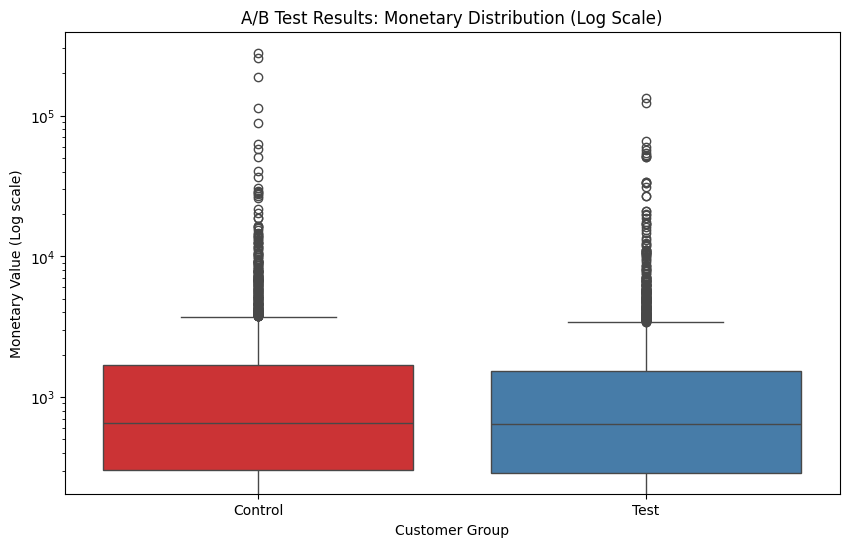

/var/folders/z_/syjjld4s2mb89bx16k6jw9lm0000gn/T/ipykernel_79732/152243814.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_data, x='Group', y='Monetary', palette="Set2", split=False)


<Figure size 1000x600 with 0 Axes>

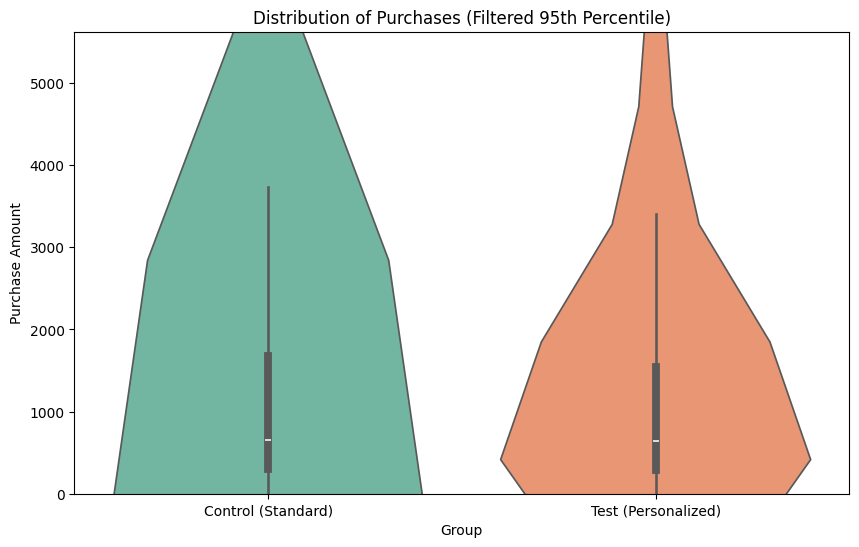

In [16]:
# Візуалізація результату
plot_data = pd.DataFrame({
    'Group': ['Control'] * len(group_control) + ['Test'] * len(group_test),
    'Monetary': pd.concat([group_control, group_test])
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=plot_data, x='Group', y='Monetary', palette="Set1")

plt.yscale('log') 
plt.title('A/B Test Results: Monetary Distribution (Log Scale)')
plt.ylabel('Monetary Value (Log scale)')
plt.xlabel('Customer Group')
plt.show()

plt.figure(figsize=(10, 6))
# Обмежуємо по 95-му перцентилю
limit = plot_data['Monetary'].quantile(0.95)

plt.figure(figsize=(10, 6))
sns.violinplot(data=plot_data, x='Group', y='Monetary', palette="Set2", split=False)
plt.ylim(0, limit) 
plt.xticks([0, 1], ['Control (Standard)', 'Test (Personalized)'])
plt.ylabel('Purchase Amount')
plt.title('Distribution of Purchases (Filtered 95th Percentile)')
plt.show()

### P-value (0.1505) > 0.05
No statistically significant difference was found between the control and experimental groups in terms of monetary indicators.

### Business Insight:
- Despite the personalization of the offer, the average customer check did not increase significantly. As can be seen in the Log Scale graph, both groups have identical median values and a similar number of VIP customers with high spending.
- The Violin Plot graph confirms that the “center of gravity” for both groups is in the low check range (up to 1,000 units), and the campaign did not change this distribution.

### Recommendation:
Do not scale this mechanism to the entire database. It is recommended to review the value of the offer or change the targeting, focusing on narrow segments (for example, only “Loyalists”).

## Churn Rate (рівень відтоку)

In [17]:
# Поріг відтоку - 90 днів
churn_threshold = 90

with open('../scripts/churn_query.sql', 'r') as f:
    sql_churn_query = f.read()

churn_data = ps.sqldf(sql_churn_query, locals())
churn_rate = (churn_data['Churned_Customers'] / churn_data['Total_Customers']) * 100

print(f"Total Churn Rate: {churn_rate.iloc[0]:.2f}%")

Total Churn Rate: 61.89%


/var/folders/z_/syjjld4s2mb89bx16k6jw9lm0000gn/T/ipykernel_79732/3267983487.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  segment_churn = rfm_raw.groupby('Segment').apply(
/var/folders/z_/syjjld4s2mb89bx16k6jw9lm0000gn/T/ipykernel_79732/3267983487.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_churn, x='Segment', y='Churn_Rate', palette='OrRd')


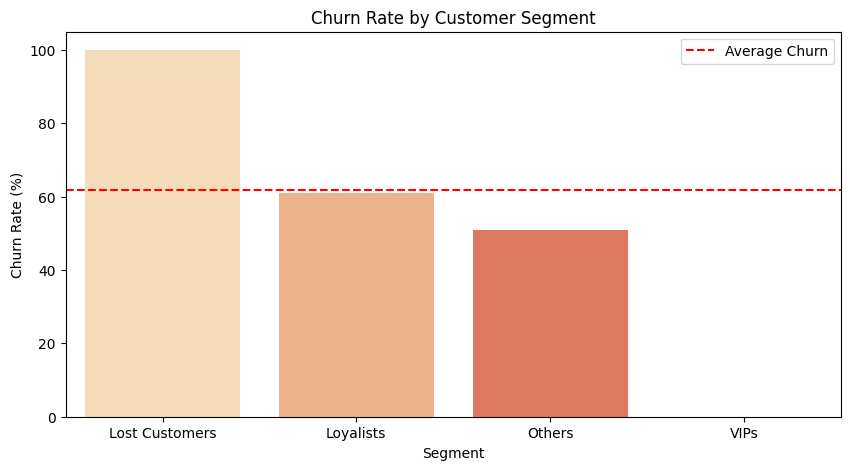

In [18]:
# Розрахунок відтоку всередині кожного сегмента
segment_churn = rfm_raw.groupby('Segment').apply(
    lambda x: (x['Recency'] > churn_threshold).mean() * 100
).reset_index(name='Churn_Rate')

plt.figure(figsize=(10, 5))
sns.barplot(data=segment_churn, x='Segment', y='Churn_Rate', palette='OrRd')
plt.axhline(churn_rate.iloc[0], color='red', linestyle='--', label='Average Churn')
plt.title('Churn Rate by Customer Segment')
plt.ylabel('Churn Rate (%)')
plt.legend()
plt.show()

### Total Churn Rate: 61.89%

### Graph analysis:
- Lost Customers (100%): The highest level expected. This confirms the accuracy of our segmentation.
- Loyalists (~60%): This is a critical risk area. The fact that 60% of loyal customers are on the verge of churn is a sign of serious retention issues.
- VIPs (0%): The best indicator. Our most valuable customers remain active.

### Action Plan:
It is necessary to urgently launch a retention campaign for the “Loyalists” segment. Since they have a high purchase history (Frequency), it is easier and cheaper to bring them back than to attract new customers.